In [1]:
import nflfastpy as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

pd.set_option('display.max_columns', 7)

In [2]:
data = pd.concat([nfl.load_pbp_data(season).assign(season=season) for season in range(2018, 2022)])

In [3]:
def dynamic_window_ewma(x):

    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)


rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()


rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()


rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))


epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2019,1,...,-0.373631,-0.057534,-0.057534
1,ARI,2019,2,...,0.240487,-0.001500,-0.001500
2,ARI,2019,3,...,0.229042,0.041580,0.041580
3,ARI,2019,4,...,0.487657,0.124517,0.124517
4,ARI,2019,5,...,0.141315,0.127627,0.127627


In [4]:
epa.to_csv(r"C:\Users\PMcki\Documents\NFL_predictor\Testweekly.csv", index = False)

In [5]:
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2019,1,MIN,...,0.225169,-0.000438,-0.000438
1,2019,1,MIA,...,-0.208817,-0.113016,-0.113016
2,2019,1,NYJ,...,-0.432246,-0.226913,-0.226913
3,2019,1,SEA,...,-0.070019,0.184793,0.184793
4,2019,1,LV,...,-0.168829,0.013535,0.013535


In [6]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
for feature in features:
  print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [7]:
df = df.dropna()

X = df.loc[df['season'] != 2021, features].values
y = df.loc[df['season'] != 2021, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [8]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.6342068483577917


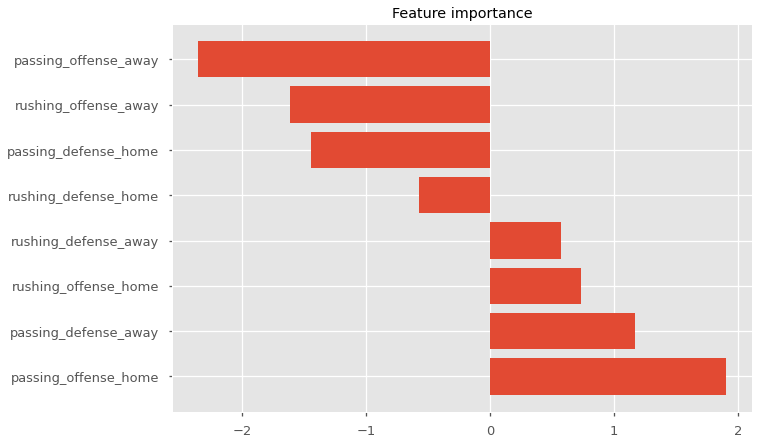

In [9]:
fig, ax = plt.subplots()

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title('Feature importance')

ax.barh(features_sorted, coef_sorted);
plt.show();

In [10]:
df_2021 = df.loc[(df['season'] == 2021)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2021['actual_winner'] = df_2021.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2021['predicted_winner'] = df_2021.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2021['win_probability'] = df_2021.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2021['correct_prediction'] = (df_2021['predicted_winner'] == df_2021['actual_winner']).astype(int)

df_2021 = df_2021.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2021.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,JAX,BUF,9,BUF,JAX,0.784078,0
1,LA,DET,7,LA,LA,0.772771,1
2,ARI,HOU,7,ARI,ARI,0.764721,1
3,HOU,LA,8,LA,LA,0.764341,1
4,ARI,CAR,10,ARI,CAR,0.759560,0
5,DET,GB,18,GB,DET,0.749997,0
6,DET,BAL,3,BAL,BAL,0.748302,1
7,NYJ,TB,17,TB,TB,0.736417,1
8,TB,CAR,18,TB,TB,0.735931,1
9,TEN,HOU,11,TEN,HOU,0.734371,0


In [11]:
correct = df_2021.loc[df_2021['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()

num_games = df_2021.groupby('week')['correct_prediction'].size()

results = correct / num_games

results

week
1     0.437500
2     0.625000
3     0.562500
4     0.625000
5     0.750000
6     0.642857
7     0.769231
8     0.600000
9     0.500000
10    0.428571
11    0.533333
12    0.600000
13    0.714286
14    0.785714
15    0.562500
16    0.750000
17    0.687500
18    0.562500
19    0.833333
20    0.250000
21    0.500000
22    1.000000
Name: correct_prediction, dtype: float64

In [12]:
print(df_2021.loc[df_2021['week'] == results.idxmax()].sort_values(by='win_probability', ascending=False))

    home_team away_team  week predicted_winner actual_winner  win_probability  \
820       CIN        LA    22               LA            LA          0.55496   

     correct_prediction  
820                   1  


In [18]:
df_2021.loc[df_2021['week'] == 1]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
536,TEN,ARI,1,TEN,ARI,0.552932,0
537,LV,BAL,1,BAL,LV,0.685555,0
538,LA,CHI,1,LA,LA,0.593037,1
539,KC,CLE,1,CLE,KC,0.541178,0
540,TB,DAL,1,TB,TB,0.666901,1
541,NYG,DEN,1,NYG,DEN,0.553375,0
542,NO,GB,1,GB,NO,0.648457,0
543,HOU,JAX,1,HOU,HOU,0.651016,1
544,WAS,LAC,1,LAC,LAC,0.560230,1
545,NE,MIA,1,MIA,MIA,0.594109,1


In [19]:
week_1 = df_2021.loc[df_2021['week'] == 1]
week_1

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
536,TEN,ARI,1,TEN,ARI,0.552932,0
537,LV,BAL,1,BAL,LV,0.685555,0
538,LA,CHI,1,LA,LA,0.593037,1
539,KC,CLE,1,CLE,KC,0.541178,0
540,TB,DAL,1,TB,TB,0.666901,1
541,NYG,DEN,1,NYG,DEN,0.553375,0
542,NO,GB,1,GB,NO,0.648457,0
543,HOU,JAX,1,HOU,HOU,0.651016,1
544,WAS,LAC,1,LAC,LAC,0.560230,1
545,NE,MIA,1,MIA,MIA,0.594109,1


In [39]:
week_1.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week1_predictions.csv", index = False)

In [40]:
week_2 =  df_2021.loc[df_2021['week'] == 2]
week_2.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week2_predictions.csv", index = False)

In [41]:
week_3 =  df_2021.loc[df_2021['week'] == 3]
week_3.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week3_predictions.csv", index = False)

In [42]:
week_4 =  df_2021.loc[df_2021['week'] == 4]
week_4.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week4_predictions.csv", index = False)

In [43]:
week_5 =  df_2021.loc[df_2021['week'] == 5]
week_5.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week5_predictions.csv", index = False)

In [44]:
week_6 =  df_2021.loc[df_2021['week'] == 6]
week_6.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week6_predictions.csv", index = False)

In [45]:
week_7 =  df_2021.loc[df_2021['week'] == 7]
week_7.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week7_predictions.csv", index = False)

In [46]:
week_8 =  df_2021.loc[df_2021['week'] == 8]
week_8.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week8_predictions.csv", index = False)

In [47]:
week_9 =  df_2021.loc[df_2021['week'] == 9]
week_9.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week9_predictions.csv", index = False)

In [48]:
week_10 =  df_2021.loc[df_2021['week'] == 10]
week_10.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week10_predictions.csv", index = False)

In [49]:
week_11 =  df_2021.loc[df_2021['week'] == 11]
week_11.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week11_predictions.csv", index = False)

In [50]:
week_12 =  df_2021.loc[df_2021['week'] == 12]
week_12.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week12_predictions.csv", index = False)

In [51]:
week_13 =  df_2021.loc[df_2021['week'] == 13]
week_13.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week13_predictions.csv", index = False)

In [52]:
week_14 =  df_2021.loc[df_2021['week'] == 14]
week_14.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week14_predictions.csv", index = False)

In [53]:
week_15 =  df_2021.loc[df_2021['week'] == 15]
week_15.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week15_predictions.csv", index = False)

In [54]:
week_16 =  df_2021.loc[df_2021['week'] == 16]
week_16.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week16_predictions.csv", index = False)

In [55]:
week_17 =  df_2021.loc[df_2021['week'] == 17]
week_17.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week17_predictions.csv", index = False)

In [56]:
week_18 =  df_2021.loc[df_2021['week'] == 18]
week_18.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week18_predictions.csv", index = False)

In [21]:
week_21 = df_2021.loc[df_2021['week'] == 21]
week_21.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week21_predictions.csv", index = False)

In [22]:
week_20 = df_2021.loc[df_2021['week'] == 20]
week_20.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week20_predictions.csv", index = False)

In [23]:
week_19 = df_2021.loc[df_2021['week'] == 19]
week_19.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week19_predictions.csv", index = False)

In [24]:
week_22 = df_2021.loc[df_2021['week'] == 22]
week_22.to_csv(r"C:\Users\PMcki\OneDrive\Documents\GitHub\FinalYearProject\FYP\nfl_data\week22_predictions.csv", index = False)